In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, f, norm
np.set_printoptions(precision= 5, suppress= True)

# Construct a model from scrach

In [10]:
class SLR():
    """
    Author: Lucius Vo <https://github.com/vohuynhquangnguyen>
    Construct a simple linear regression (SLR) model and conduct required estimations and hypothesis test.
    Methods of estimating the model's parameters and hypothesis test are based on Mendenhall and Sincich (2013, p.96-165).

    References:
    1. Mendenhall, William, Sincich, Terry T. A Second Course in Statistics - Regression Analysis (7th Edition). Pearson, 2013
    2. Montgomery, Douglas C., Runger, George C. Applied Statistics and Probability for Engineer (7th Edition). Wiley, 2018
    """
    def __init__(self) -> None:
        super(SLR, self).__init__
        pass

    def load_data(self, src: str, X_header: str, Y_header: str):
        """
        Load the dataset from a .csv file using Pandas file handler.
        """
        df = pd.read_csv(src)
        self.X_header = X_header; self.Y_header = Y_header
        self.X = np.array(df[X_header])
        self.Y = np.array(df[Y_header])
        pass

    def fit(self):
        """
        Compute the parameters of the fitted model using the ordinary least square (OLS) method.
        """
        self.Xbar = np.mean(self.X)
        self.Ybar = np.mean(self.Y)

        self.SS_xx = sum((np.power(x - self.Xbar, 2) for x in self.X))
        self.SS_yy = sum((np.power(y - self.Ybar, 2) for y in self.Y))
        self.SS_xy = sum(((x - self.Xbar) * (y - self.Ybar) for (x,y) in zip(self.X,self.Y)))

        self.B1hat = self.SS_xy / self.SS_xx
        self.B0hat = self.Ybar - self.B1hat * self.Xbar
        pass

    def estimate_variance_residuals(self):
        """
        Estimate the variance of residuals.
        """
        self.e = np.array([y - (self.B0hat + self.B1hat * x) for (x,y) in zip(self.X, self.Y)])
        self.SS_E = sum((np.power(y - (self.B0hat + self.B1hat * x), 2) for (x,y) in zip(self.X, self.Y)))
        self.s2 = self.SS_E / (len(self.Y) - 2)
        pass

    def ANOVA(self):
        """
        Conduct the analysis of variance (ANOVA) on the fitted model.
        """
        self.SS_R = sum((np.power((self.B0hat + self.B1hat * x) - self.Ybar, 2) for x in self.X))
        self.SS_T = self.SS_R + self.SS_E
        self.Rsquare = self.SS_R / self.SS_T
        pass

    def conduct_statistical_inference(self, level: float = 0.95):
        """
        Conduct the hypothesis tests on the fitted model at the significant level (default is 95%).
        """
        self.level = level
        self.estimate_variance_residuals()
        self.ANOVA()

        # Test on the estimated slope and intercept (two-tailed T-test):
        t_c = t.ppf((1 - level)/2, df = len(self.Y) - 2)
        self.SE_B1hat = np.power(self.s2 / self.SS_xx, 1/2)
        self.T_B1hat = (self.B1hat - 0) / self.SE_B1hat
        self.SE_B0hat = np.power(self.s2 * ( 1 / len(self.Y) + self.Xbar ** 2 / self.SS_xx), 1/2)
        self.T_B0hat = (self.B0hat - 0) / self.SE_B0hat

        self.pval_B1 = t.sf(abs(self.T_B1hat), len(self.Y) - 2) * 2
        self.pval_B0 = t.sf(abs(self.T_B0hat), len(self.Y) - 2) * 2

        # Test on the Pearson correlation coefficient (two-tailed T-test):
        self.r = np.power(self.SS_xy / (self.SS_xx * self.SS_yy), 1/2)
        self.t_r = np.power(self.r * ((len(self.Y) - 2) / (1 - self.r ** 2)), 1/2)
        self.pval_r = t.sf(abs(self.t_r), df = len(self.Y) - 2) * 2

        # Test on the significant of regression (two-tailed T-test):
        self.F = (self.SS_R / 1) / (self.SS_E / (len(self.Y) - 2))
        self.pval_F = f.sf(self.F, 1, len(self.Y) - 2)
        pass

    def compute_intervals(self, level: float = 0.95):
        """
        Compute the confidence intervals and the prediction intervals:
        """
        t_c = t.ppf((1 - level)/2, df = len(self.Y) - 2)

        # Confidence interval for the parameters:
        self.B0hat_CI_lwr = self.B0hat - t_c * self.SE_B0hat
        self.B0hat_CI_upr = self.B0hat + t_c * self.SE_B0hat

        self.B1hat_CI_lwr = self.B1hat - t_c * self.SE_B1hat
        self.B1hat_CI_upr = self.B1hat + t_c * self.SE_B1hat

        # Confidence interval of mean response at x:
        self.func = lambda x: self.B0hat + self.B1hat * x
        self.Yhat_CI_lwr = lambda x: \
          self.B0hat + self.B1hat * x - t_c * np.sqrt(self.s2 * (1/len(self.Y) + np.power(x - self.Xbar,2) / (self.SS_xx)))
        self.Yhat_CI_upr = lambda x: \
          self.B0hat + self.B1hat * x + t_c * np.sqrt(self.s2 * (1/len(self.Y) + np.power(x - self.Xbar,2) / (self.SS_xx)))

        # Prediction interval of mean response at x:
        self.yhat_PI_lwr = lambda x: \
          self.B0hat + self.B1hat * x - t_c * np.sqrt(self.s2 * (1 + 1/len(self.Y) + np.power(x - self.Xbar,2) / (self.SS_xx)))
        self.yhat_PI_upr = lambda x: \
          self.B0hat + self.B1hat * x + t_c * np.sqrt(self.s2 * (1 + 1/len(self.Y) + np.power(x - self.Xbar,2) / (self.SS_xx)))
        pass

    def visualize(self):
        """
        Visualize the entire analysis process:
        """

        # Visualize the distribution of the dataset:
        fig, axs = plt.subplots(1, 2, figsize = (8,4), dpi = 100)
        nbins = \
         (np.max(self.X) - np.min(self.X)) * np.power(len(self.Y), 1/3) / (3.49 * np.std(self.X, ddof= 1))
        sns.histplot(self.X, bins = int(nbins), ax = axs[0])
        axs[0].set_title(f"Histogram of {self.X_header}")
        axs[0].grid(True)

        nbins = \
         (np.max(self.Y) - np.min(self.Y)) * np.power(len(self.Y), 1/3) / (3.49 * np.std(self.Y, ddof= 1))
        sns.histplot(self.Y, bins = int(nbins), ax = axs[1])
        axs[1].set_title(f"Histogram of {self.Y_header}")
        axs[1].grid(True)
        fig.tight_layout()

        # Visualize the regression analysis:
        fig, axs = plt.subplots(1, 3, figsize = (15,4), dpi = 100)
        sns.scatterplot({f"{self.X_header}": self.X, f"{self.Y_header}": self.Y},
                        x =  f"{self.X_header}", y = f"{self.Y_header}", ax = axs[0])
        sns.lineplot({"x": self.X, "y": self.func(self.X)},
                     x = "x", y = "y", color = 'red', linestyle = 'solid', linewidth = 1.0, ax = axs[0])
        sns.lineplot({"x": self.X, "y": self.Yhat_CI_lwr(self.X)},
                     x = "x", y = "y", color = 'red', linestyle = 'dashdot', linewidth = 0.75, ax = axs[0])
        sns.lineplot({"x": self.X, "y": self.Yhat_CI_upr(self.X)},
                     x = "x", y = "y", color = 'red', linestyle = 'dashdot', linewidth = 0.75, ax = axs[0])
        sns.lineplot({"x": self.X, "y": self.yhat_PI_lwr(self.X)},
                     x = "x", y = "y", color = 'red', linestyle = 'dotted', linewidth = 0.55, ax = axs[0])
        sns.lineplot({"x": self.X, "y": self.yhat_PI_upr(self.X)},
                     x = "x", y = "y", color = 'red', linestyle = 'dotted', linewidth = 0.55, ax = axs[0])
        axs[0].set_title(f"{self.Y_header} vs. {self.X_header}")
        axs[0].grid(True)

        # Visualize the residual analysis:
        sns.scatterplot({f"{self.Y_header}": self.Y, "Residual": self.e},
                        x = f"{self.Y_header}", y = "Residual",
                        ax = axs[1])
        axs[1].axhline(y = 0, color = 'red', linestyle = 'dashed', linewidth = 1.0)
        axs[1].set_title(f"Residual Plot")
        axs[1].grid(True)

        rank = np.array([(i - 0.375) / (len(self.Y) + 0.25) for i in range(1, len(self.Y) + 1)])
        z_e = np.array([norm.ppf(i) for i in rank])
        sns.scatterplot({"Residual": sorted(self.e), "Z-score": z_e},
                        x = "Residual", y = "Z-score", ax = axs[2])
        axs[2].set_title(f"Residual Normality Plot")
        axs[2].grid(True)
        fig.tight_layout()
        pass

    def generate_report(self):
        """
        Generate a regression analysis report.
        """
        print(f"\nModel: {self.Y_header} ~ {self.X_header}")
        print(f"\n\t  Min \t Q1 \t Median \t Q3 \tMax")
        print(f"Residuals: {np.min(self.e):.5f} \t {np.quantile(self.e, 0.25):.5f} \t {np.median(self.e):.5f} \t {np.quantile(self.e, 0.75):.5f} \t {np.max(self.e):.5f}")

        print(f"\n\t  Coefficient \t Std. Error \t Lower-bound CI \t Upper-bound CI \t t-Statistic \t Pr(>|t|) at {100 * self.level}%")
        print(f"Intercept: {self.B0hat:.5f} \t {self.SE_B0hat:.5f} \t {self.B0hat_CI_lwr:.5f} \t {self.B0hat_CI_upr:.5f} \t {self.T_B0hat:.5f} \t {self.pval_B0:.5f}")
        print(f"{self.X_header}: {self.B1hat:.5f} \t {self.SE_B1hat:.5f} \t {self.B1hat_CI_lwr:.5f} \t {self.B1hat_CI_upr:.5f} \t {self.T_B1hat:.5f} \t {self.pval_B1:.5f}")

        print(f"\nResidual Std. Error: {np.power(self.s2,1/2):.5f} on {len(self.Y) - 2} DF")
        print(f"R-square: {self.Rsquare:.5f}")
        print(f"Pearson correlation coef.: {self.r:.5f}, p-value: {self.pval_r:.5f}")
        print(f"F-statistic: {self.F:.5f} on 1 predictor and {len(self.Y) - 2} DF, p-value: {self.pval_F:.5f}")
        pass

    def run(self):
        """
        """
        self.fit()
        self.estimate_variance_residuals()
        self.conduct_statistical_inference()
        self.compute_intervals()
        self.generate_report()
        self.visualize()
        pass



Model: Sale_Price ~ Market_Val

	  Min 	 Q1 	 Median 	 Q3 	Max
Residuals: -282.17064 	 -24.82893 	 1.80737 	 29.79117 	 188.79201

	  Coefficient 	 Std. Error 	 Lower-bound CI 	 Upper-bound CI 	 t-Statistic 	 Pr(>|t|) at 95.0%
Intercept: 1.35868 	 13.76817 	 28.79237 	 -26.07501 	 0.09868 	 0.92166
Market_Val: 1.40827 	 0.03693 	 1.48186 	 1.33468 	 38.13216 	 0.00000

Residual Std. Error: 68.75660 on 74 DF
R-square: 0.95157
Pearson correlation coef.: 0.00044, p-value: 0.85705
F-statistic: 1454.06189 on 1 predictor and 74 DF, p-value: 0.00000


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

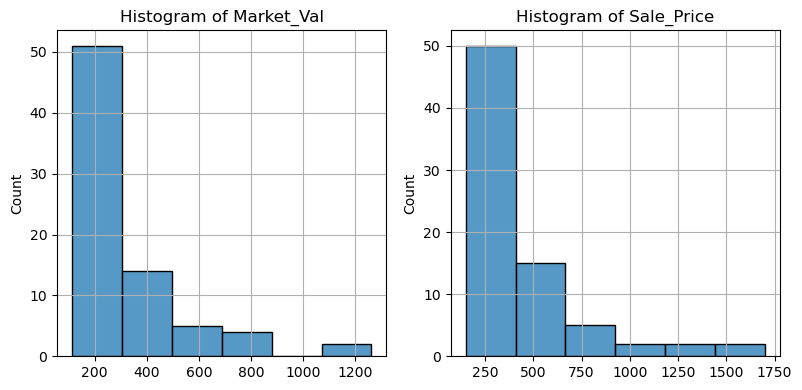

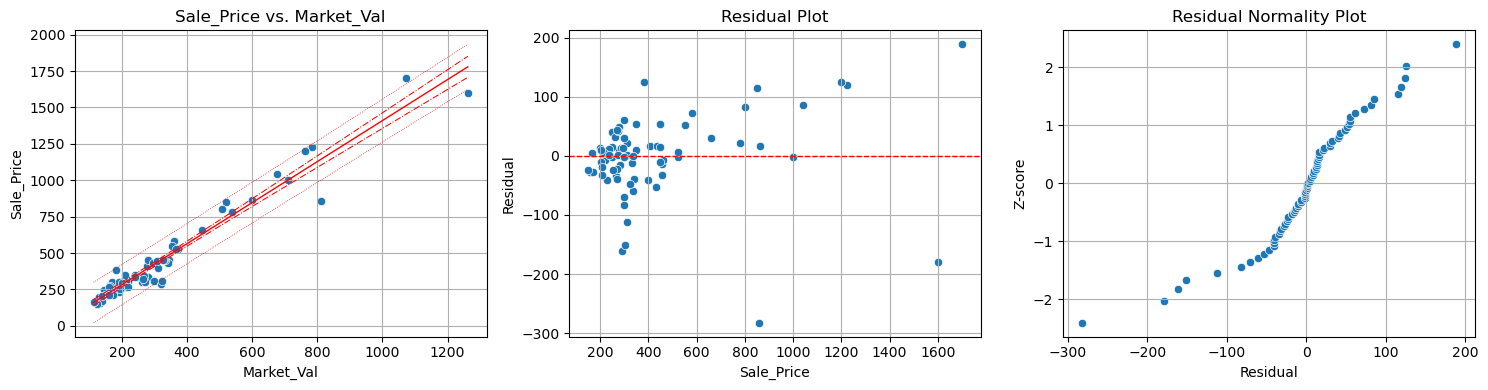

In [11]:
slr = SLR()
slr.load_data("./dataset/TAMPALMS.csv", "Market_Val", "Sale_Price")
slr.run()

# Construct a model using scikit-learn